In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the images directory
images_path = 'PP_Micro'  # Adjust this path to your specific setup

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    labels = []
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(filename.split('_')[0])  # Assuming filename format is 'label_id.jpg'
    return images, labels

# Function to preprocess images
def preprocess_images(images, size=(224, 224)):
    images_resized = [cv2.resize(img, size) for img in images]
    images_normalized = np.array(images_resized) / 255.0  # Normalize pixel values
    return images_normalized



In [2]:
# Load and preprocess images
from tensorflow.keras.utils import to_categorical
images, labels = load_images_from_folder(images_path)
images_preprocessed = preprocess_images(images)

# Encode labels - simple numerical encoding and convert to one-hot
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 base model without the top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')  # Assuming 3 classes for the task
])

model.summary()


In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.001,
    verbose=1
)

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(images_preprocessed, labels_one_hot, test_size=0.1, random_state=42)

# Prepare to collect scores
fold_no = 1
loss_per_fold = []
accuracy_per_fold = []

for train_idx, val_idx in kfold.split(X_train, Y_train):
    print(f'Training fold {fold_no}...')
    
    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        batch_size=32,
        epochs=20,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}; Accuracy = {scores[1]*100}%')
    loss_per_fold.append(scores[0])
    accuracy_per_fold.append(scores[1] * 100)

    # Increment the fold number
    fold_no += 1

# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print(f'Average scores for all folds: Accuracy: {np.mean(accuracy_per_fold):.2f}%, Loss: {np.mean(loss_per_fold):.2f}')
print('------------------------------------------------------------------------')


Training fold 1...
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 917ms/step - accuracy: 0.1465 - loss: 2.8765 - val_accuracy: 0.1949 - val_loss: 2.2295 - learning_rate: 0.0010
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 797ms/step - accuracy: 0.1500 - loss: 2.3314 - val_accuracy: 0.1186 - val_loss: 2.3483 - learning_rate: 0.0010
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 803ms/step - accuracy: 0.1813 - loss: 2.3993 - val_accuracy: 0.1356 - val_loss: 2.2606 - learning_rate: 0.0010
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 806ms/step - accuracy: 0.1841 - loss: 2.2073 - val_accuracy: 0.1695 - val_loss: 2.0719 - learning_rate: 0.0010
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 807ms/step - accuracy: 0.1927 - loss: 2.1029 - val_accuracy: 0.2203 - val_loss: 2.0746 - learning_rate: 0.0010
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 819ms/step - accuracy: 0.1586 - loss: 2.0576 - val_accuracy: 0.1525 - val_loss: 2.0493 - learning_rate: 0.0010
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 783ms/step - accuracy

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_val_fold, y_val_fold)
print(f"Validation accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.2313 - loss: 1.9107
Validation accuracy: 0.21367521584033966


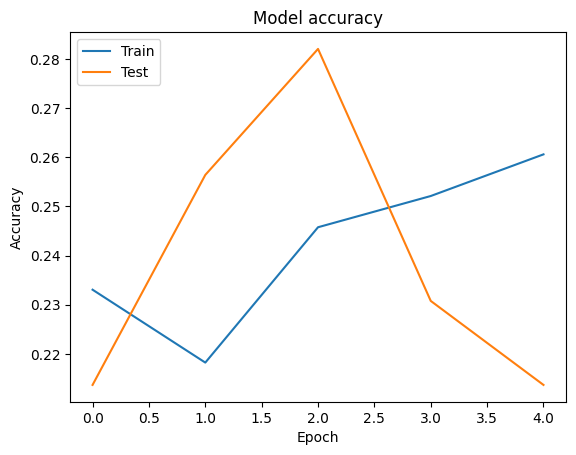

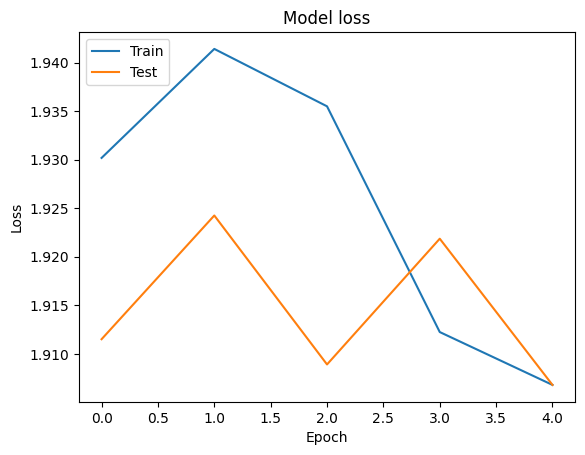

In [8]:
# Plot training & test accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_val_fold, axis=1), np.argmax(model.predict(X_val_fold),axis=1)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.12      0.19      0.15        16
           2       0.43      0.18      0.25        17
           3       0.20      0.71      0.31        17
           4       0.19      0.25      0.22        16
           5       1.00      0.23      0.38        13
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        12

    accuracy                           0.21       117
   macro avg       0.24      0.19      0.16       117
weighted avg       0.24      0.21      0.17       117



c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tricks\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step


<Axes: xlabel='Predicted', ylabel='Actual'>

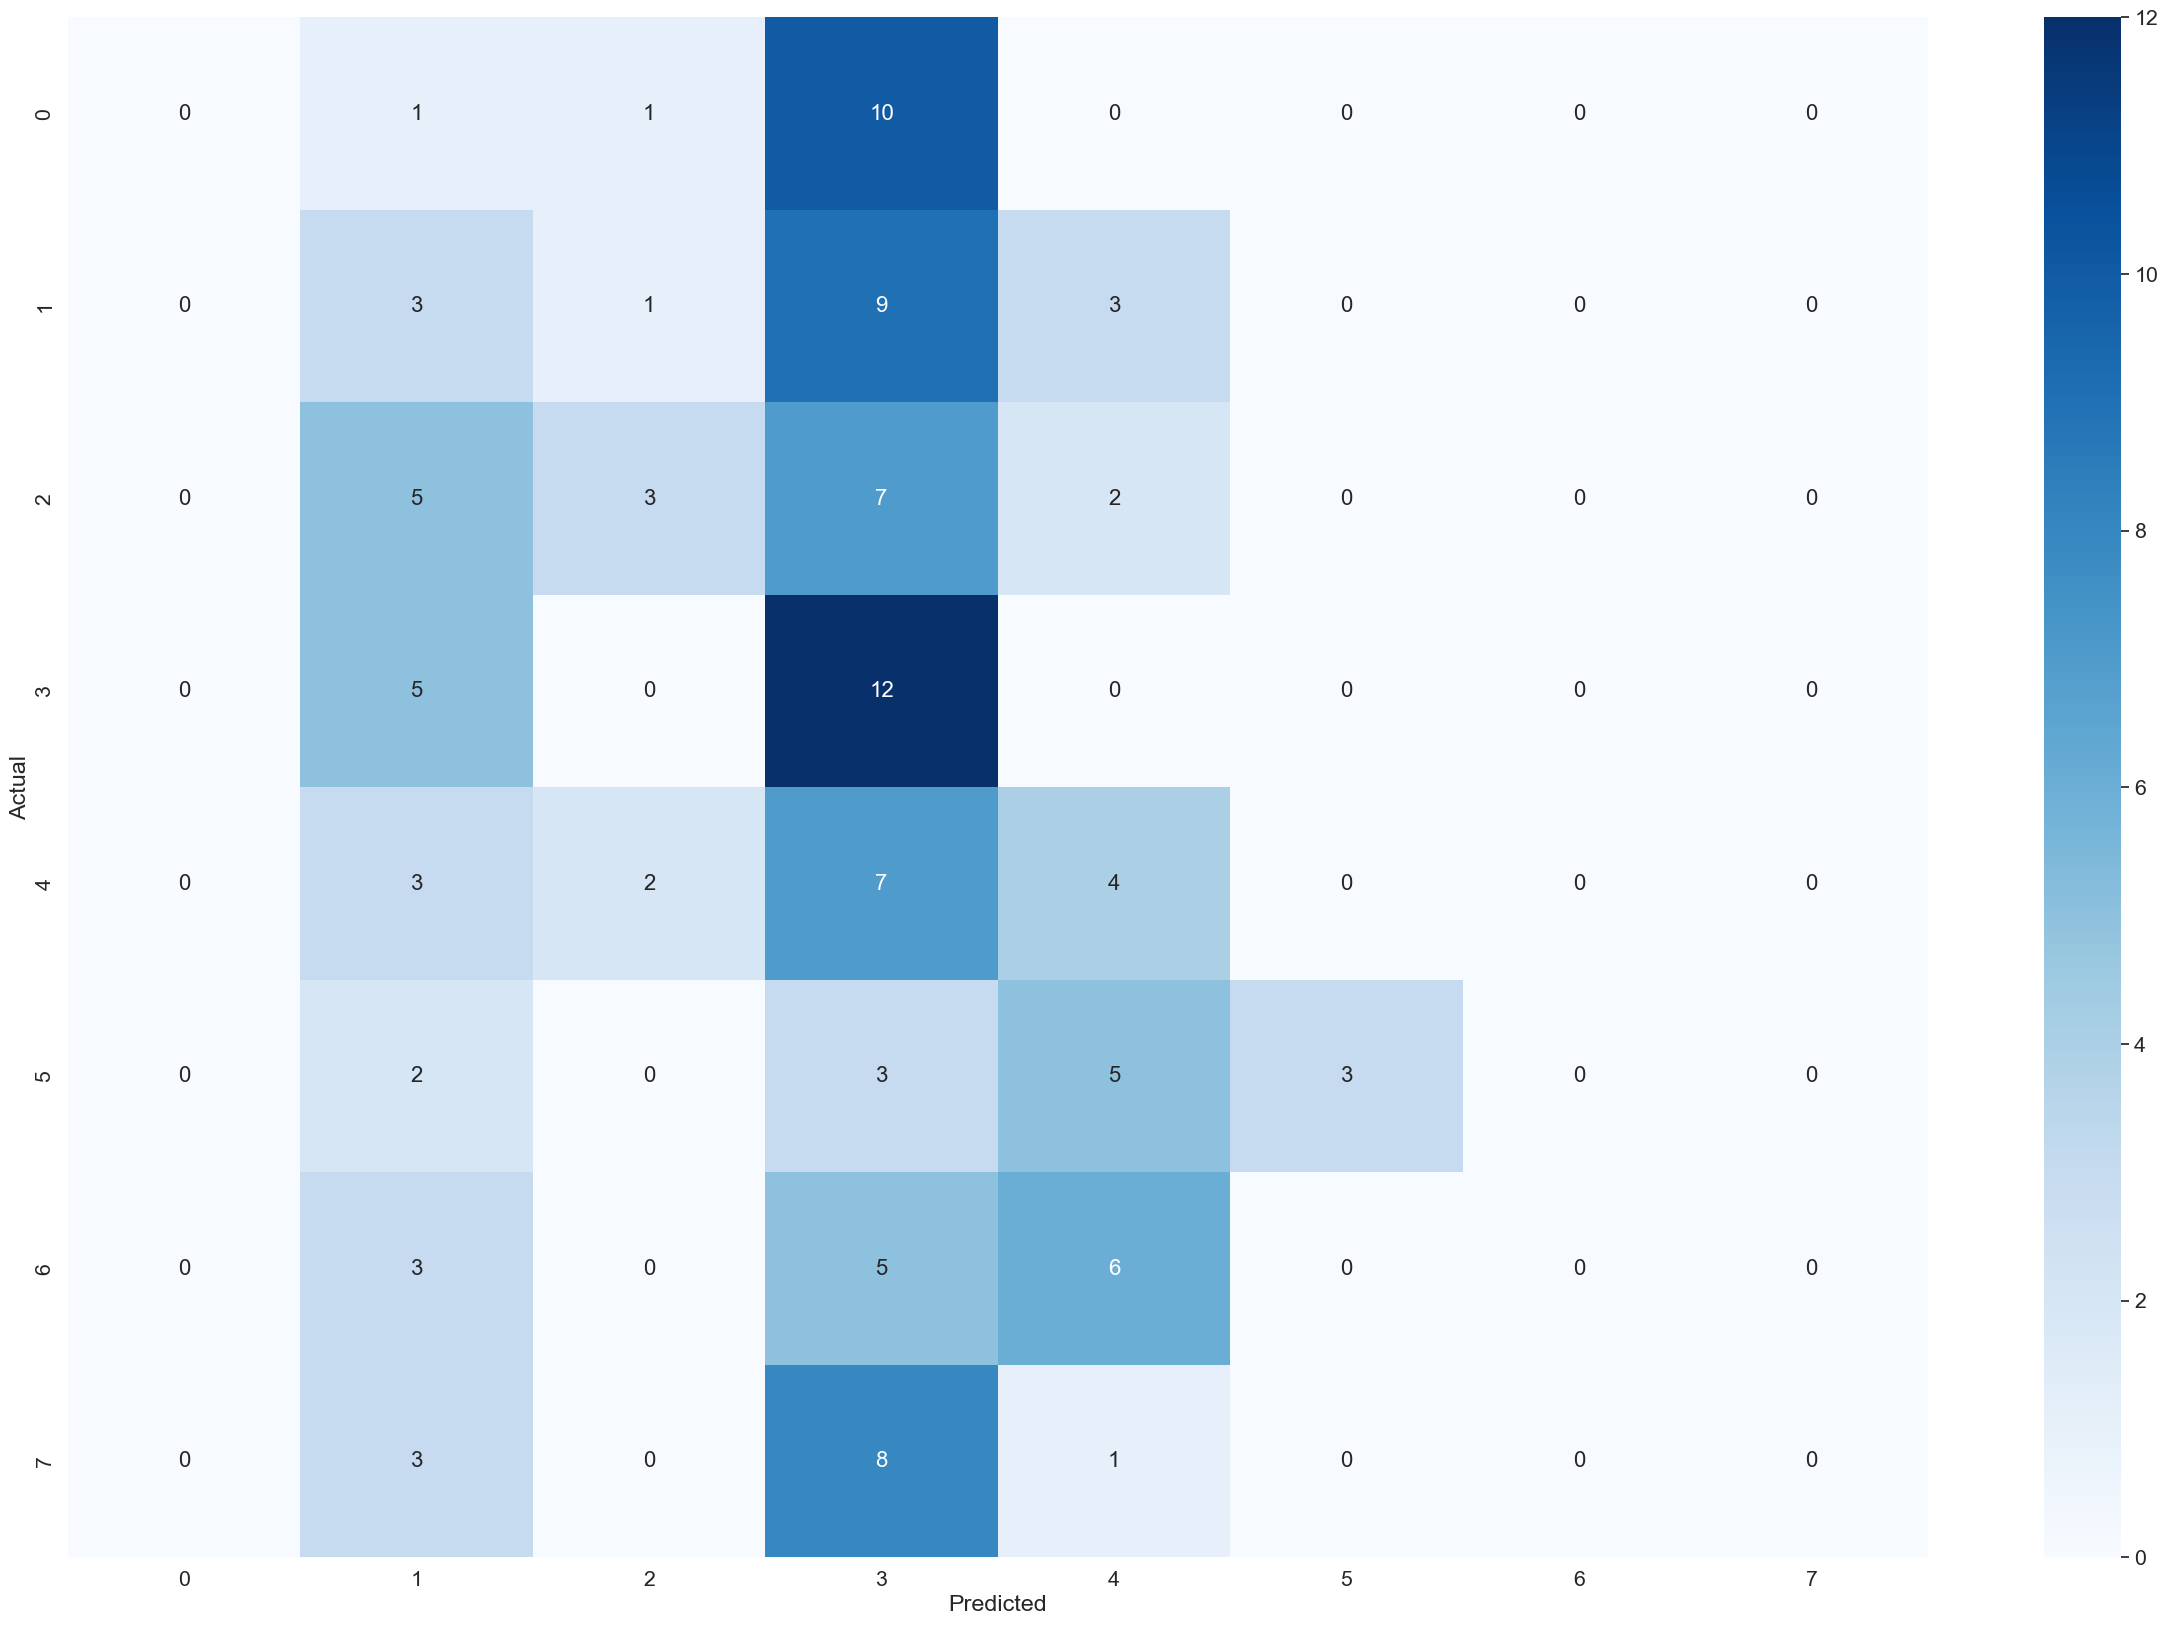

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
y_true = np.argmax(y_val_fold, axis=1)
y_pred = np.argmax(model.predict(X_val_fold), axis=1)
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


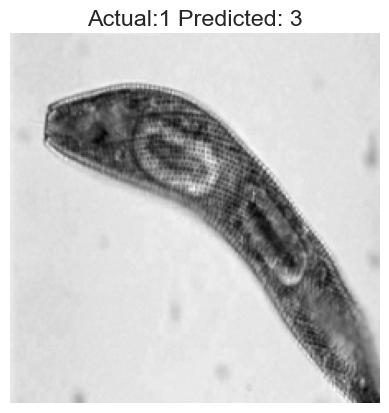

In [31]:
rand_n = np.random.randint(X_val_fold.shape[0])
plt.imshow(X_val_fold[rand_n][:, :, 0], cmap='gray')
plt.title(f'Actual:{np.argmax(y_val_fold[rand_n])} Predicted: {np.argmax(model.predict(X_val_fold[rand_n].reshape(-1, 224, 224, 3)))}');
plt.axis('off')
plt.show()